In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.clim_loss_vit import custom_loss
#from utils.clim_loss import ClimateDownscalingLoss

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-12-19 22:33:50.553880: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 22:33:50.570813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734669230.589555   47405 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734669230.595147   47405 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 22:33:50.619085: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_tas_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_tas = xr.open_zarr(cmip6_tas_path)

cmip6_pr_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_pr = xr.open_zarr(cmip6_pr_path)
cmip6_lat = cmip6_pr.lat
cmip6_lon = cmip6_pr.lon

cmip6_psl_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_psl = xr.open_zarr(cmip6_psl_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_tas_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_tas = xr.open_mfdataset(gmfd_tas_files, combine='by_coords')
gmfd_pr_files = [f'{gmfd_data_path}/prcp_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_pr = xr.open_mfdataset(gmfd_pr_files, combine='by_coords')
gmfd_pr['prcp'] = gmfd_pr['prcp'] * 86400

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_tas.lat
target_lon = gmfd_tas.lon
cmip6_high_tas = cmip6_tas['tas'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_pr = cmip6_pr['pr'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_pr = cmip6_high_pr.where(cmip6_high_pr > 0, 0)  # Set negative values to zero
cmip6_high_pr = cmip6_high_pr * 86400
cmip6_high_psl = cmip6_psl['psl'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_high_tas['time'] = cmip6_high_tas['time'].dt.floor('D')
cmip6_high_pr['time'] = cmip6_high_pr['time'].dt.floor('D')

#### Load elevation

In [3]:
elev = xr.open_dataset('grids/elevation_0.25deg.nc')
elev_sub = elev.sel(latitude=slice(40.99986, 51.49986), longitude=slice( 6.69986, 30.99986 ))
elev_sub['elev'] = elev_sub['elev'].fillna(0) # convert NA to 0
elev_sub = elev_sub.rename({"latitude": "lat"})
elev_sub = elev_sub.rename({"longitude": "lon"})
# Rename the dimension and coordinate


elev_cmip6 = elev_sub.interp(lat=cmip6_lat, lon=cmip6_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
elev_cmip6['elev'] = elev_cmip6['elev'].clip(min=0)
cmip6_high_elev = elev_cmip6.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

# Set cmip6_high_elev to 0 where cmip6_high_elev < 0 and elev_sub == 0
cmip6_high_elev = xr.where((cmip6_high_elev < 0) & (elev_sub['elev'] == 0), 0, cmip6_high_elev)
cmip6_high_elev['elev'] = cmip6_high_elev['elev'].clip(min=0)
elev_dif = elev_sub - cmip6_high_elev


# Check the new shape of 'elev'
elev_dif = elev_dif.squeeze(dim="z")

# elev_cmip6['elev'].plot(cmap = 'terrain')
# elev_dif_norm.plot(cmap = 'terrain')
# elev_dif['elev'].plot(cmap = 'terrain')


#### Transform (pr) and normalize

In [4]:
# Apply the log1p transformation to the 'prcp' variable
cmip6_high_pr_log1p = cmip6_high_pr.copy()  # Make a copy to avoid modifying the original dataset
# Apply the log1p transformation to the precipitation data
cmip6_high_pr_log1p = xr.apply_ufunc(
    np.log1p,                 # The function to apply (log1p)
   cmip6_high_pr,               # The data variable to transform
    dask="parallelized",      # Enable parallel computations with Dask
    output_dtypes=[float]     # Specify output data type
)

# Apply the log1p transformation to the 'prcp' variable
gmfd_pr_log1p = gmfd_pr.copy()  # Make a copy to avoid modifying the original dataset
# Apply the log1p transformation to the precipitation data
gmfd_pr_log1p['prcp'] = xr.apply_ufunc(
    np.log1p,                 # The function to apply (log1p)
    gmfd_pr['prcp'],               # The data variable to transform
    dask="parallelized",      # Enable parallel computations with Dask
    output_dtypes=[float]     # Specify output data type
)

In [5]:
def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

cmip6_tas_norm = normalize(cmip6_high_tas)
cmip6_psl_norm = normalize(cmip6_high_psl)
cmip6_pr_norm = normalize(cmip6_high_pr_log1p)
gmfd_tas_norm = normalize(gmfd_tas['tas'])
gmfd_pr_norm = normalize(gmfd_pr_log1p['prcp'])
elev_dif_norm = normalize(elev_dif['elev'])


# Convert data to NumPy arrays for use in Keras
cmip6_train_tas = cmip6_tas_norm.values
cmip6_train_psl = cmip6_psl_norm.values
cmip6_train_pr = cmip6_pr_norm.values
gmfd_train_pr = gmfd_pr_norm.values
gmfd_train_tas = gmfd_tas_norm.values
elev_dif_norm = elev_dif_norm.values

In [6]:
print(elev_dif_norm.shape)
print(gmfd_train_tas.shape)
elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], 23741, axis=0)
print(elev_dif_norm_final.shape)

(1, 42, 97)
(23741, 42, 97)
(23741, 42, 97)


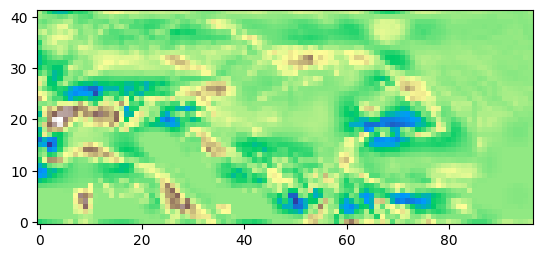

In [7]:
plt.imshow(elev_dif_norm_final[10000, :,:], origin='lower', cmap='terrain')

#### Compute residuals

In [8]:
import xarray as xr

res_tas = gmfd_train_tas  - cmip6_train_tas
res_pr = gmfd_train_pr  - cmip6_train_pr

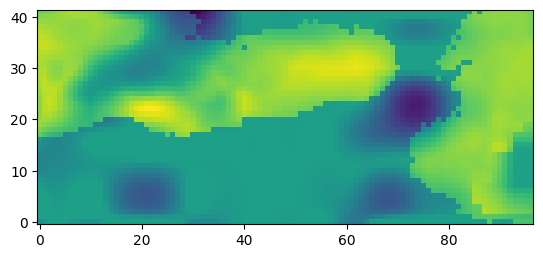

In [9]:
plt.imshow(res_pr[100, :,:], origin='lower', cmap='viridis')

#### Split the data
Train set: The first portion of the time period (e.g., 60% of the time series).
Validation set: The next portion of the time series (e.g., the following 20% of the time series).
Test set: The final portion of the time series (e.g., the last 20%): 

In [10]:
import pandas as pd
index_2004 = int(np.where(cmip6_tas_norm.time.values == pd.to_datetime('2004-12-31'))[0][0])
index_2009 = int(np.where(cmip6_tas_norm.time.values == pd.to_datetime('2009-12-31'))[0][0])

In [11]:
# Reshape data to add the channel dimension
cmip6_train_tas_reshaped = cmip6_train_tas[..., np.newaxis]
cmip6_train_pr_reshaped = cmip6_train_psl[..., np.newaxis]
cmip6_train_slp_reshaped = cmip6_train_psl[..., np.newaxis]
elev_dif_norm_reshaped = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_train_combined = np.concatenate((cmip6_train_tas_reshaped,cmip6_train_pr_reshaped, cmip6_train_slp_reshaped, elev_dif_norm_reshaped), axis=-1)

gmfd_train_tas_reshaped = gmfd_train_tas[..., np.newaxis]
gmfd_train_pr_reshaped = gmfd_train_pr[..., np.newaxis]

gmfd_train_combined = np.concatenate((gmfd_train_tas_reshaped,gmfd_train_pr_reshaped), axis=-1)

res_tas_reshaped = res_tas[..., np.newaxis]
res_pr_reshaped = res_pr[..., np.newaxis]

res_train_combined = np.concatenate((res_tas_reshaped, res_pr_reshaped), axis=-1)

In [12]:
# Split the data while preserving the temporal structure
X_train = cmip6_train_combined[:index_2004]
y_train = gmfd_train_combined[:index_2004]
res_train = res_train_combined[:index_2004]

X_val = cmip6_train_combined[index_2004:index_2009]
y_val = gmfd_train_combined[index_2004:index_2009]
res_val = res_train_combined[index_2004:index_2009]

X_test = cmip6_train_combined[index_2009:]
y_test = gmfd_train_combined[index_2009:]
res_test = res_train_combined[index_2009:]


# # Reshape X data to include the temporal dimension
# X_train = np.expand_dims(X_train, axis=1)
# X_val = np.expand_dims(X_val, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

# # Reshape y data to include the temporal dimension
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

# # Reshape y data to include the temporal dimension
# res_train = np.expand_dims(res_train, axis=1)
# res_val = np.expand_dims(res_val, axis=1)
# res_test = np.expand_dims(res_test, axis=1)


In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(res_train.shape)
print(res_val.shape)
print(res_test.shape)

(20088, 42, 97, 4)
(1826, 42, 97, 4)
(1827, 42, 97, 4)
(20088, 42, 97, 2)
(1826, 42, 97, 2)
(1827, 42, 97, 2)


#### Create temporal sequences

In [14]:
def create_temporal_sequences_centered(data, window_size):
    total_seq_length = 2 * window_size + 1
    sequences = []
    
    # For all time points
    for i in range(len(data)):
        sequence = np.zeros((total_seq_length,) + data.shape[1:])
        
        # Handle past values
        for j in range(window_size):
            if i - j >= 0:  # If we have data for this past point
                sequence[window_size - j] = data[i - j]
            else:  # If we don't have data, use the earliest available
                sequence[window_size - j] = data[0]
        
        # Current value
        sequence[window_size] = data[i]
        
        # Handle future values
        for j in range(window_size):
            if i + j + 1 < len(data):  # If we have data for this future point
                sequence[window_size + j + 1] = data[i + j + 1]
            else:  # If we don't have data, use the last available
                sequence[window_size + j + 1] = data[-1]
        
        sequences.append(sequence)
    
    return np.array(sequences)

window_size = 3

In [15]:
X_train_seq = create_temporal_sequences_centered(X_train, window_size)  
X_val_seq = create_temporal_sequences_centered(X_val, window_size)      
X_test_seq = create_temporal_sequences_centered(X_test, window_size)     
y_train_seq = create_temporal_sequences_centered(y_train, window_size) 
y_val_seq = create_temporal_sequences_centered(y_val, window_size)     
y_test_seq = create_temporal_sequences_centered(y_test, window_size)   

res_train_seq = create_temporal_sequences_centered(res_train, window_size) 
res_val_seq = create_temporal_sequences_centered(res_val, window_size)     
res_test_seq = create_temporal_sequences_centered(res_test, window_size) 

print("X_train shape:", X_train_seq.shape)
print("X_val shape:", X_val_seq.shape)
print("y_train shape:", y_train_seq.shape)
print("y_val shape:", y_val_seq.shape)
print("res_train shape:", res_train_seq.shape)
print("res_val shape:", res_val_seq.shape)

res_train_seq = res_train_seq.astype(np.float32)  # Add this line
res_val_seq = res_val_seq.astype(np.float32)    

X_train_seq = X_train_seq.astype(np.float32)  # Add this line
X_val_seq = X_val_seq.astype(np.float32)   


X_train shape: (20088, 7, 42, 97, 4)
X_val shape: (1826, 7, 42, 97, 4)
y_train shape: (20088, 7, 42, 97, 2)
y_val shape: (1826, 7, 42, 97, 2)
res_train shape: (20088, 7, 42, 97, 2)
res_val shape: (1826, 7, 42, 97, 2)


#### Build the GAN (Keras with Tensofflow Backend)


In [35]:
from keras.layers import LeakyReLU, Flatten, GlobalAveragePooling3D, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, AdamW
from keras import ops
from keras.layers import (
    Input,
    Dense,
    Dropout,
    MultiHeadAttention,
    LayerNormalization,
    Add,
    Conv3D,
    Reshape,
    TimeDistributed,
    Layer,
)
from keras.models import Model, Sequential
from keras import regularizers
from keras.saving import register_keras_serializable
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
import numpy as np

# **Fourier Positional Encoding Layer**
@register_keras_serializable()
class FourierPositionalEncoding(Layer):
    def __init__(self, embed_dim, max_freq=10, **kwargs):
        """
        Fourier positional encoding for spatial and temporal positions.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.max_freq = max_freq

    def call(self, inputs):
        """
        Compute Fourier positional encodings and add them to the inputs.
        """
        batch_size, seq_len, embed_dim = ops.shape(inputs)

        # Generate positional values (normalized between 0 and 1)
        positions = ops.linspace(0.0, 1.0, seq_len)

        # Generate frequency bands
        freq_bands = ops.power(
            2.0, ops.linspace(0.0, self.max_freq, self.embed_dim // 2)
        )

        # Compute Fourier features
        encodings = ops.matmul(
            ops.expand_dims(positions, axis=-1), ops.expand_dims(freq_bands, axis=0)
        )
        sin_encodings = ops.sin(encodings)
        cos_encodings = ops.cos(encodings)

        # Concatenate sine and cosine encodings
        positional_encodings = ops.concatenate([sin_encodings, cos_encodings], axis=-1)
        positional_encodings = ops.expand_dims(
            positional_encodings, axis=0
        )  # Add batch dimension
        positional_encodings = ops.broadcast_to(
            positional_encodings, [batch_size, seq_len, embed_dim]
        )

        # Add positional encodings to inputs
        return inputs + positional_encodings

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim": self.embed_dim, "max_freq": self.max_freq})
        return config

# **Residual Multi-Scale Patch Embedding Layer**
@register_keras_serializable()
class ResidualMultiScalePatchEmbedding(Layer):
    def __init__(self, patch_size, embed_dim, num_scales=3, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_scales = num_scales

    def build(self, input_shape):
        self.convs = [
            Conv3D(
                filters=self.embed_dim // self.num_scales,
                kernel_size=(k, k, k),
                strides=self.patch_size,
                padding="same",
                name=f"scale_{k}x{k}x{k}",
            )
            for k in range(3, 3 + self.num_scales)  # Dynamic kernel sizes
        ]
        self.fusion = Conv3D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=1,
            padding="same",
            name="multi_scale_fusion",
        )
        self.residual_proj = Conv3D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=self.patch_size,
            padding="same",
            name="residual_projection",
        )

    def call(self, x):
        batch_size = ops.shape(x)[0]
        multi_scale_features = [conv(x) for conv in self.convs]
        combined_features = ops.concatenate(multi_scale_features, axis=-1)
        fused_features = self.fusion(combined_features)
        residual = self.residual_proj(x)
        fused_features += residual
        _, t, h, w, c = ops.shape(fused_features)
        return ops.reshape(fused_features, (batch_size, t * h * w, c))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "patch_size": self.patch_size,
                "embed_dim": self.embed_dim,
                "num_scales": self.num_scales,
            }
        )
        return config

# **Spatial-Temporal Attention Block**
@register_keras_serializable()
class SpatialTemporalAttentionBlock(Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout, weight_decay, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.weight_decay = weight_decay

    def build(self, input_shape):
        # Unified Spatial-Temporal Attention
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads,
            dropout=self.dropout,
        )
        # Layer normalizations
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Feed-forward network (MLP)
        self.mlp = Sequential(
            [
                Dense(
                    self.mlp_dim,
                    activation="gelu",
                    kernel_regularizer=regularizers.L2(self.weight_decay),
                ),
                Dropout(self.dropout),
                Dense(
                    self.embed_dim,
                    kernel_regularizer=regularizers.L2(self.weight_decay),
                ),
                Dropout(self.dropout),
            ]
        )

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        x = Add()([inputs, attn_output])
        x = self.layernorm1(x)

        # Feed-forward network (MLP)
        mlp_output = self.mlp(x)
        return self.layernorm2(Add()([x, mlp_output]))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "mlp_dim": self.mlp_dim,
                "dropout": self.dropout,
                "weight_decay": self.weight_decay,
            }
        )
        return config

# **ViT Transformer** (Modified for 2-channel output)
def vit_transformer(
    input_shape,
    patch_size,
    embed_dim,
    num_heads,
    transformer_layers,
    mlp_dim,
    dropout,
    weight_decay,
):
    inputs = Input(shape=input_shape)
    x = ResidualMultiScalePatchEmbedding(
        patch_size=patch_size, embed_dim=embed_dim, num_scales=3
    )(inputs)
    x = FourierPositionalEncoding(embed_dim=embed_dim, max_freq=10)(x)

    for _ in range(transformer_layers):
        x = SpatialTemporalAttentionBlock(
            embed_dim=embed_dim,
            num_heads=num_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            weight_decay=weight_decay,
        )(x)

    num_time_steps = input_shape[0]
    _, num_patches, embed_dim = ops.shape(x)
    num_spatial_patches = num_patches // num_time_steps
    x = Reshape((num_time_steps, num_spatial_patches * embed_dim))(x)

    x = TimeDistributed(
        Dense(
            units=mlp_dim // 2,
            activation="gelu",
            kernel_regularizer=regularizers.L2(weight_decay),
        )
    )(x)
    x = TimeDistributed(Dropout(dropout))(x)
    total_units_per_timestep = input_shape[1] * input_shape[2] * 2  # 2 channels output
    x = TimeDistributed(
        Dense(
            units=total_units_per_timestep,
            activation="linear",
            kernel_regularizer=regularizers.L2(weight_decay),
        )
    )(x)
    x = TimeDistributed(
        Reshape(target_shape=(input_shape[1], input_shape[2], 2))
    )(x)  # Output shape for 2 channels

    return Model(inputs, x)

# Generator Model
def generator_model(
    input_shape,
    patch_size,
    embed_dim,
    num_heads,
    transformer_layers,
    mlp_dim,
    dropout,
    weight_decay,
):
    generator = vit_transformer(
        input_shape=input_shape,
        patch_size=patch_size,
        embed_dim=embed_dim,
        num_heads=num_heads,
        transformer_layers=transformer_layers,
        mlp_dim=mlp_dim,
        dropout=dropout,
        weight_decay=weight_decay,
    )
    return generator

# --- Discriminator Model ---
@tf.keras.utils.register_keras_serializable()
# Discriminator Model (Modified for 2-channel input)
def discriminator_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv3D(34, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.2))(inputs)
    x = Dropout(0.1)(x)
    x = Conv3D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.2))(x)
    x = Dropout(0.1)(x)
    x = Conv3D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.2))(x)
    x = Dropout(0.1)(x)
    x = Conv3D(256, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(0.2))(x)  # New layer
    x = Dropout(0.1)(x)  # New layer
    x = GlobalAveragePooling3D()(x)
    x = Flatten()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs, name="Discriminator")




# --- Model Setup ---
input_shape = (7, 42, 97, 4)  # Low-resolution input dimensions
residual_shape = (7, 42, 97, 2) # High-resolution residual dimensions
patch_size = (7, 7, 7)

# Instantiate generator and discriminator
generator = generator_model(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=240,
    num_heads=8,
    transformer_layers=6,
    mlp_dim=256,
    dropout=0.2,
    weight_decay=0.001,
)

discriminator = discriminator_model(input_shape=residual_shape) # Discriminator should match residual shape

generator.summary()
discriminator.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 7, 42, 97, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_multi_scale_patch_emb… │ (None, 84, 240)        │       128,400 │
│ (ResidualMultiScalePatchEmbedd… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_positional_encoding_1   │ (None, 84, 240)        │             0 │
│ (FourierPositionalEncoding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 84, 240)        │       355,696 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 84, 240)        │       355,696 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 84, 240)        │       355,696 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 84, 240)        │       355,696 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 84, 240)        │       355,696 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 84, 240)        │       355,696 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 2880)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 7, 128)         │       368,768 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 7, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 7, 8148)        │     1,051,092 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 7, 42, 97, 2)   │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,682,436 (14.05 MB)

 Trainable params: 3,682,436 (14.05 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 7, 42, 97, 2)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 4, 21, 49, 34)  │         1,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 4, 21, 49, 34)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 2, 11, 25, 64)  │        58,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 2, 11, 25, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 1, 6, 13, 128)  │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 1, 6, 13, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 1, 3, 7, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 1, 3, 7, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,167,247 (4.45 MB)

 Trainable params: 1,167,247 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [17]:
print(X_train_seq.shape)

(20088, 7, 42, 97, 4)


In [36]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
from tensorflow.keras.utils import register_keras_serializable
import numpy as np

# --- GAN Model ---
@register_keras_serializable()
class GAN(Model):
    def __init__(self, generator, discriminator, **kwargs):
        super(GAN, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(
        self,
        generator_optimizer,
        discriminator_optimizer,
        generator_loss_fn,
        discriminator_loss_fn,
    ):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss_fn = generator_loss_fn
        self.discriminator_loss_fn = discriminator_loss_fn

    @tf.function(jit_compile=True)
    def train_step(self, data):
        input_lr, real_images = data

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(input_lr, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            generator_loss = self.generator_loss_fn(real_images, generated_images)
            discriminator_loss = self.discriminator_loss_fn(real_output, fake_output)

        # --- Gradient Calculation ---
        generator_gradients = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)

        # --- Gradient Clipping ---
        generator_gradients = [tf.clip_by_norm(g, 1.0) for g in generator_gradients] # Example clipping value
        discriminator_gradients = [tf.clip_by_norm(g, 1.0) for g in discriminator_gradients]

        # --- Apply Gradients ---
        self.generator_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradients, self.discriminator.trainable_variables))

        return {"generator_loss": generator_loss, "discriminator_loss": discriminator_loss}

    def call(self, inputs, training=False):
        return self.generator(inputs, training=training)

# --- Hyperparameters ---
epochs = 500
batch_size = 100
weight_decay = 0.1
learning_rate = 1e-4

# --- Model Setup ---
input_shape = (7, 42, 97, 4)
residual_shape = (7, 42, 97, 2)
patch_size = (7, 7, 7)

# Replace with actual generator and discriminator models
generator = generator_model(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=240,
    num_heads=8,
    transformer_layers=6,
    mlp_dim=256,
    dropout=0.2,
    weight_decay=0.001,
)
discriminator = discriminator_model(input_shape=residual_shape)

gan = GAN(generator=generator, discriminator=discriminator)
gan.generator.build(input_shape=(None, *input_shape))

# --- Loss Functions ---
def generator_loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def discriminator_loss_fn(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(real_output) * 0.9, real_output))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(fake_output) + 0.1, fake_output))
    return real_loss + fake_loss

# --- Compile GAN ---
g_optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
d_optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
gan.compile(
    generator_optimizer=g_optimizer,
    discriminator_optimizer=d_optimizer,
    generator_loss_fn=generator_loss_fn,
    discriminator_loss_fn=discriminator_loss_fn,
)

# --- Callbacks ---
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr_g = self.model.generator_optimizer.learning_rate
        lr_d = self.model.discriminator_optimizer.learning_rate
        print(f"Epoch {epoch + 1} - Generator LR: {lr_g.numpy()}, Discriminator LR: {lr_d.numpy()}")

callbacks = [
    EarlyStopping(
        monitor="val_content_loss", patience=15, restore_best_weights=True, min_delta=5e-4, mode="min"
    ),
    ModelCheckpoint(
        filepath="models/gan_generator_best.keras", monitor="val_content_loss", save_best_only=True, mode="min"
    ),
    TerminateOnNaN(),
    LearningRateLogger(),
]
for callback in callbacks:
    callback.set_model(gan)

 # --- Early Stopping Variables ---
early_stopping_patience = 15
min_delta = 5e-4
best_val_loss = float("inf")
best_epoch = -1
wait = 0

# --- Training Loop ---
g_losses, d_losses, val_content_losses = [], [], []

for epoch in range(epochs):
    epoch_g_loss, epoch_d_loss = 0, 0

    # Training loop
    for step in range(X_train_seq.shape[0] // batch_size):
        idx = np.random.randint(0, X_train_seq.shape[0], batch_size)
        input_lr = X_train_seq[idx]
        input_hr = res_train_seq[idx]

        losses = gan.train_step((input_lr, input_hr))
        epoch_g_loss += losses["generator_loss"]
        epoch_d_loss += losses["discriminator_loss"]

    avg_gen_loss = epoch_g_loss / (X_train_seq.shape[0] // batch_size)
    avg_disc_loss = epoch_d_loss / (X_train_seq.shape[0] // batch_size)
    g_losses.append(avg_gen_loss)
    d_losses.append(avg_disc_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")

    # Validation
    if epoch % 5 == 0:
        val_losses = []
        for val_step in range(X_val_seq.shape[0] // batch_size):
            idx_val = np.random.randint(0, X_val_seq.shape[0], batch_size)
            input_lr_val = X_val_seq[idx_val]
            input_hr_val = res_val_seq[idx_val]

            generated_hr_val = gan.generator(input_lr_val, training=False)
            val_content_loss = tf.reduce_mean(tf.square(input_hr_val - generated_hr_val)).numpy()
            val_losses.append(val_content_loss)

        avg_val_loss = np.mean(val_losses)
        val_content_losses.append(avg_val_loss)
        print(f"Validation Content Loss: {avg_val_loss:.4f}")

        # Early Stopping Logic
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            wait = 0
            # Save best model
            gan.generator.save("models/gan_generator_best.keras")
        else:
            wait += 1
            print(f"EarlyStopping wait: {wait}/{early_stopping_patience}")

        if wait >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}, best epoch was {best_epoch + 1} with val_loss={best_val_loss:.4f}")
            break

2024-12-19 22:53:03.990232: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_173', 4 bytes spill stores, 4 bytes spill loads

2024-12-19 22:53:09.991168: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 68 bytes spill stores, 68 bytes spill loads

2024-12-19 22:53:14.918262: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20378', 48 bytes spill stores, 48 bytes spill loads

2024-12-19 22:53:16.052973: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 132 bytes spill stores, 132 bytes spill loads

2024-12-19 22:53:31.551744: I external/local_xla/xla/stream_exec

Epoch 1/500 - Generator Loss: 0.0287, Discriminator Loss: 1.1837
Validation Content Loss: 0.0271
Epoch 2/500 - Generator Loss: 0.0273, Discriminator Loss: 1.1066
Epoch 3/500 - Generator Loss: 0.0270, Discriminator Loss: 1.1065
Epoch 4/500 - Generator Loss: 0.0267, Discriminator Loss: 1.1065
Epoch 5/500 - Generator Loss: 0.0264, Discriminator Loss: 1.1064
Epoch 6/500 - Generator Loss: 0.0265, Discriminator Loss: 1.1064
Validation Content Loss: 0.0272
EarlyStopping wait: 1/15
Epoch 7/500 - Generator Loss: 0.0263, Discriminator Loss: 1.1064
Epoch 8/500 - Generator Loss: 0.0263, Discriminator Loss: 1.1064
Epoch 9/500 - Generator Loss: 0.0259, Discriminator Loss: 1.1064
Epoch 10/500 - Generator Loss: 0.0255, Discriminator Loss: 1.1064
Epoch 11/500 - Generator Loss: 0.0251, Discriminator Loss: 1.1065
Validation Content Loss: 0.0251
Epoch 12/500 - Generator Loss: 0.0248, Discriminator Loss: 1.1065
Epoch 13/500 - Generator Loss: 0.0247, Discriminator Loss: 1.1065
Epoch 14/500 - Generator Loss:

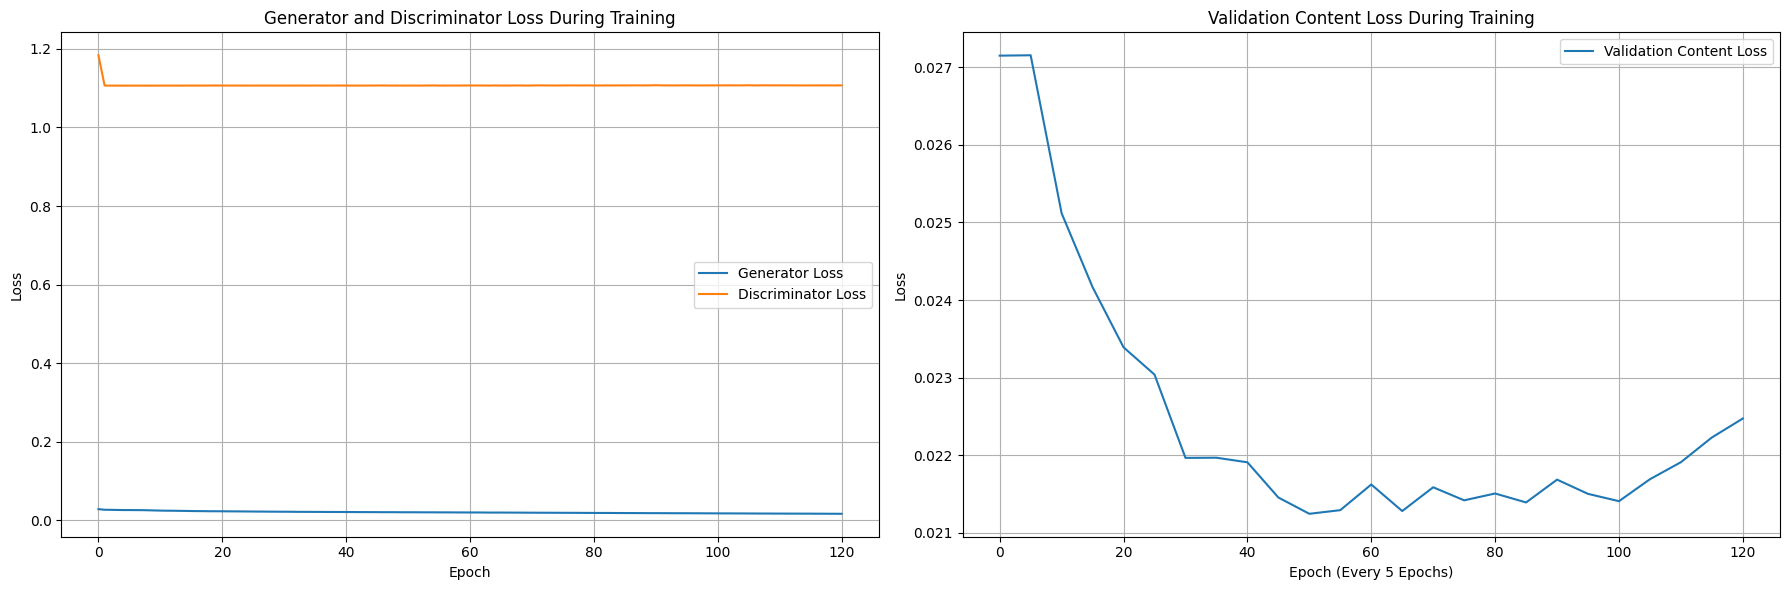

In [37]:
import matplotlib.pyplot as plt

# Adjust x-axis ticks for validation losses to reflect epochs every 5 steps
val_epochs = list(range(0, len(val_content_losses) * 5, 5))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # Create a figure with 1 row, 2 columns of subplots

# 1. Generator and Discriminator Losses (Left Subplot)
axes[0].plot(g_losses, label='Generator Loss')
axes[0].plot(d_losses, label='Discriminator Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Generator and Discriminator Loss During Training')
axes[0].legend()
axes[0].grid(True)

# 2. Validation Content Loss (Right Subplot)
axes[1].plot(val_epochs, val_content_losses, label='Validation Content Loss')
axes[1].set_xlabel('Epoch (Every 5 Epochs)')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Content Loss During Training')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


#### Evaluate the model on validation data

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the model

from keras.models import load_model
#model_saved = generator
model_saved = load_model('models/gan_generator_best.keras')

In [39]:
# Get the mean and std from the training set for denormalization
cmip6_high_tas_min = cmip6_high_tas.min().values
cmip6_high_tas_max = cmip6_high_tas.max().values
cmip6_high_pr_min = cmip6_high_pr_log1p.min().values
cmip6_high_pr_max = cmip6_high_pr_log1p.max().values

# Get the mean and std from the training set for denormalization
gmfd_min_tas = gmfd_tas['tas'].min().values
gmfd_max_tas = gmfd_tas['tas'].max().values
gmfd_min_pr = gmfd_pr_log1p['prcp'].min().values
gmfd_max_pr = gmfd_pr_log1p['prcp'].max().values

In [40]:
# Generate predictions on validation data
y_pred = model_saved.predict(X_test_seq)

56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-12-20 00:32:40.227763: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_55_0', 100 bytes spill stores, 100 bytes spill loads

2024-12-20 00:32:40.847129: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65_0', 100 bytes spill stores, 100 bytes spill loads

2024-12-20 00:32:41.402226: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4_0', 84 bytes spill stores, 84 bytes spill loads



58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step


In [41]:

# put back the residuals
y_pred_tas = X_test_seq[:,window_size,:,:,0] +  y_pred[:,window_size,:,:,0]
y_pred_pr = X_test_seq[:,window_size,:,:,1] +  y_pred[:,window_size,:,:,1]

print(y_pred.shape)
print(y_test_seq[:,window_size,:,:,0].shape)
# Back-transform the predictions for evaluation
y_test_denorm_tas = y_test_seq[:,window_size,:,:,0] * (gmfd_max_tas - gmfd_min_tas) + gmfd_min_tas
y_pred_denorm_tas = y_pred_tas * (cmip6_high_tas_max - cmip6_high_tas_min) + cmip6_high_tas_min

y_test_denorm_pr = y_test_seq[:,window_size,:,:,1] * (gmfd_max_pr - gmfd_min_pr) + gmfd_min_pr
y_pred_denorm_pr = y_pred_pr * (cmip6_high_pr_max - cmip6_high_pr_min) + cmip6_high_pr_min
# back transform from log1p
y_pred_denorm_pr_back = np.expm1(y_pred_denorm_pr)
y_test_denorm_pr_back = np.expm1(y_test_denorm_pr)
y_pred_denorm_pr_back[y_pred_denorm_pr_back < 0] = 0



(1827, 7, 42, 97, 2)
(1827, 42, 97)


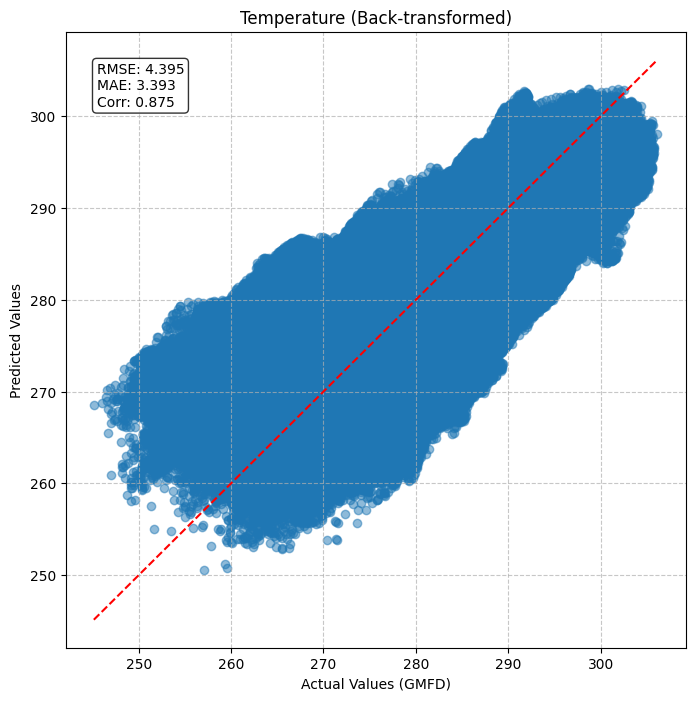

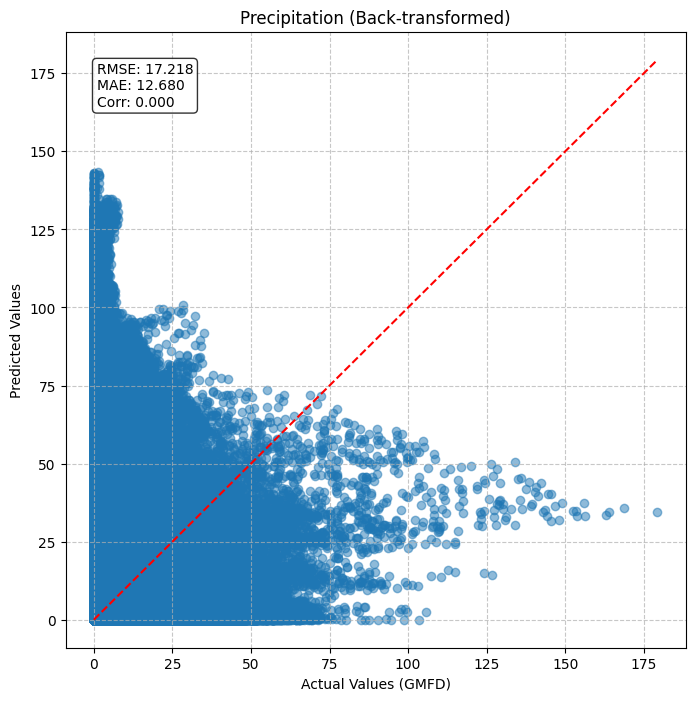

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_plot(y_test_denorm, y_pred_denorm, title="Predicted vs Actual"):
    """
    Calculates RMSE, MAE, and correlation, and generates a scatter plot
    of predicted vs. actual values.

    Args:
        y_test_denorm (np.ndarray): The actual/observed (denormalized) values.
        y_pred_denorm (np.ndarray): The predicted (denormalized) values.
        title (str, optional): The title of the plot. Defaults to "Predicted vs Actual".
    """

    # Calculate RMSE, MAE, and correlation
    rmse = np.sqrt(mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten()))
    mae = mean_absolute_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
    correlation = np.corrcoef(y_test_denorm.flatten(), y_pred_denorm.flatten())[0,1]

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
    plt.scatter(y_test_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
    plt.xlabel('Actual Values (GMFD)')
    plt.ylabel('Predicted Values')
    plt.title(f'{title} (Back-transformed)')
    plt.plot([y_test_denorm.min(), y_test_denorm.max()],
            [y_test_denorm.min(), y_test_denorm.max()], 'r--')

    # Add RMSE, MAE, and correlation text to the upper left
    plt.text(0.05, 0.95, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nCorr: {correlation:.3f}',
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

evaluate_and_plot(y_test_denorm_tas, y_pred_denorm_tas, title="Temperature")
evaluate_and_plot(y_test_denorm_pr_back, y_pred_denorm_pr_back, title="Precipitation")




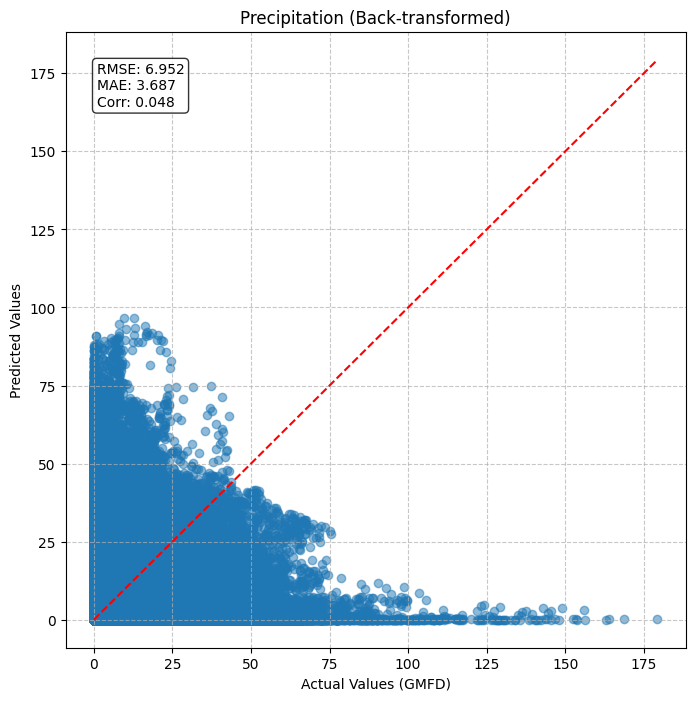

In [44]:
evaluate_and_plot( gmfd_pr['prcp'].values[index_2009:], cmip6_high_pr.values[index_2009:], title="Precipitation")

#### Train the on All Data
Train the model on all the data (no splitting)

In [ ]:
X_all = np.concatenate((X_train_seq, X_val_seq, X_test_seq), axis=0)
y_all = np.concatenate((y_train_seq, y_val_seq, y_test_seq), axis=0)
res_all = np.concatenate((res_train_seq, res_val_seq, res_test_seq), axis=0)

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN, ReduceLROnPlateau

# --- Hyperparameters ---
epochs = 500
batch_size = 100
weight_decay = 0.01
lambda_gp = 10  # Gradient penalty weight

# --- Model Setup ---
input_shape = (7, 42, 97, 4)  # Low-resolution input dimensions
residual_shape = (7, 42, 97, 2)  # High-resolution residual dimensions
patch_size = (7, 7, 7)

# Instantiate generator and discriminator (assuming these are defined elsewhere and you've made the suggested architectural changes)
model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=320,
    num_heads=10,
    transformer_layers=8,
    mlp_dim=512,
    dropout=0.2,
    weight_decay=weight_decay
)

discriminator = discriminator_model(
    input_shape=residual_shape
)  # Discriminator should match residual shape and have NO sigmoid at the output

# --- Optimizers ---
g_optimizer = AdamW(learning_rate=1e-4, weight_decay=weight_decay)
d_optimizer = AdamW(learning_rate=5e-5, weight_decay=weight_decay)  # Lower discriminator LR

# --- Loss Functions (Wasserstein Loss) ---
def generator_loss_fn(fake_output):
    # We want the generator to create outputs that the discriminator classifies as real,
    # so we want to maximize D(fake), which is equivalent to minimizing -D(fake).
    return -tf.reduce_mean(fake_output)

def discriminator_loss_fn(real_output, fake_output):
    # We want the discriminator to output high scores for real images and low scores for fake images.
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

# --- Gradient Penalty ---
def gradient_penalty(real_samples, fake_samples, discriminator):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weighted average between real and fake samples
    alpha = tf.random.uniform(shape=[real_samples.shape[0], 1, 1, 1, 1], minval=0., maxval=1.)
    interpolated_samples = (alpha * real_samples) + ((1 - alpha) * fake_samples)

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated_samples)
        # 1. Get the discriminator output for this interpolated sample.
        pred = discriminator(interpolated_samples, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated sample.
    grads = gp_tape.gradient(pred, [interpolated_samples])[0]

    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3, 4]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

# --- GAN Class (Modified for WGAN-GP) ---
@keras.saving.register_keras_serializable()
class WGAN(Model):
    def __init__(self, generator, discriminator, **kwargs):
        # Remove lambda_gp from kwargs before passing it to super().__init__()
        lambda_gp = kwargs.pop('lambda_gp') 
        super(WGAN, self).__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.lambda_gp = lambda_gp  # Store it as an attribute of the class

    def compile(
        self,
        generator_optimizer,
        discriminator_optimizer,
        generator_loss_fn,
        discriminator_loss_fn,
    ):
        super(WGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss_fn = generator_loss_fn
        self.discriminator_loss_fn = discriminator_loss_fn

    @tf.function(jit_compile=True)
    def train_step(self, data):
        # Unpack the data
        input_lr, real_images = data

        # 1. Train the discriminator
        for _ in range(5):  # Train the discriminator more than the generator (e.g., 5 times)
            with tf.GradientTape() as disc_tape:
                # Generate high-resolution images from low-resolution input
                generated_images = self.generator(input_lr, training=True)

                # Get discriminator outputs for real and fake images
                real_output = self.discriminator(real_images, training=True)
                fake_output = self.discriminator(generated_images, training=True)

                # Calculate the discriminator loss
                disc_loss = self.discriminator_loss_fn(real_output, fake_output)

                # Calculate the gradient penalty
                gp = gradient_penalty(real_images, generated_images, self.discriminator)

                # Add the gradient penalty to the total discriminator loss
                total_disc_loss = disc_loss + self.lambda_gp * gp

            # Compute discriminator gradients
            discriminator_gradients = disc_tape.gradient(
                total_disc_loss, self.discriminator.trainable_variables
            )

            # Apply discriminator updates
            self.discriminator_optimizer.apply_gradients(
                zip(discriminator_gradients, self.discriminator.trainable_variables)
            )

        # 2. Train the generator
        with tf.GradientTape() as gen_tape:
            # Generate high-resolution images from low-resolution input
            generated_images = self.generator(input_lr, training=True)

            # Get discriminator output for generated images (we want them to "fool" the discriminator)
            fake_output = self.discriminator(generated_images, training=True)

            # Calculate the generator loss (maximize D(fake), which is the same as minimizing -D(fake))
            gen_loss = self.generator_loss_fn(fake_output)

        # Compute generator gradients
        generator_gradients = gen_tape.gradient(
            gen_loss, self.generator.trainable_variables
        )

        # Apply generator updates
        self.generator_optimizer.apply_gradients(
            zip(generator_gradients, self.generator.trainable_variables)
        )

        return {
            "generator_loss": gen_loss,
            "discriminator_loss": total_disc_loss,
            "gradient_penalty": gp
        }

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "generator": self.generator,
                "discriminator": self.discriminator,
                "lambda_gp": self.lambda_gp, # Add lambda_gp to the config
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        # Create a new dictionary for the config without 'lambda_gp'
        new_config = {k: v for k, v in config.items() if k != 'lambda_gp'}
        # Create the instance using the modified config
        instance = cls(**new_config)
        # Set lambda_gp separately
        instance.lambda_gp = config['lambda_gp']
        return instance
    

    def call(self, inputs, training=False):
        return self.generator(inputs, training=training)

# Create the WGAN object
wgan = WGAN(generator=model, discriminator=discriminator, lambda_gp=lambda_gp)

# Compile the WGAN
wgan.compile(
    generator_optimizer=g_optimizer,
    discriminator_optimizer=d_optimizer,
    generator_loss_fn=generator_loss_fn,
    discriminator_loss_fn=discriminator_loss_fn,
)

# --- Callbacks ---
callbacks = [
    EarlyStopping(
        monitor="val_content_loss",
        patience=8,  # Reduced patience
        restore_best_weights=True,
        min_delta=5e-4,
        mode="min",
    ),
    ModelCheckpoint(
        filepath="models/gan_generator_best.keras",
        monitor="val_content_loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        verbose=1,
    ),
    TerminateOnNaN(),
    ReduceLROnPlateau(
        monitor='val_content_loss',
        factor=0.6,  # More gradual reduction
        patience=8,  # Increased patience
        min_lr=1e-6,
        verbose=1
    )
]

# --- Set the model for each callback ---
for callback in callbacks:
    if isinstance(callback, tf.keras.callbacks.ModelCheckpoint):
        callback.set_model(model)  # Use the generator model for checkpointing
    else:
        callback.set_model(wgan)  # Use the WGAN model

# --- Call on_train_begin for each callback ---
for callback in callbacks:
    callback.on_train_begin()

# --- Training Loop ---
g_losses, d_losses, val_content_losses, gp_values = [], [], [], [] # Added list to store gradient penalty values

for epoch in range(epochs):
    epoch_g_loss, epoch_d_loss, epoch_gp = 0, 0, 0 # Added variable to track gradient penalty

    for step in range(X_train_seq.shape[0] // batch_size):
        # Select a random batch of data
        idx = np.random.randint(0, X_train_seq.shape[0], batch_size)
        input_lr = X_train_seq[idx]  # Low-resolution input (CMIP6)
        input_hr = res_train_seq[idx]  # High-resolution target (residuals)

        # Training step
        losses = wgan.train_step((input_lr, input_hr))
        gen_loss = losses["generator_loss"]
        disc_loss = losses["discriminator_loss"]
        gp = losses["gradient_penalty"]

        epoch_g_loss += gen_loss
        epoch_d_loss += disc_loss
        epoch_gp += gp

    # Compute average losses for the epoch
    avg_gen_loss = epoch_g_loss / (X_train_seq.shape[0] // batch_size)
    avg_disc_loss = epoch_d_loss / (X_train_seq.shape[0] // batch_size)
    avg_gp = epoch_gp / (X_train_seq.shape[0] // batch_size)
    g_losses.append(avg_gen_loss)
    d_losses.append(avg_disc_loss)
    gp_values.append(avg_gp)

    # Print epoch losses
    print(
        f"Epoch {epoch + 1}/{epochs} - Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}, Gradient Penalty: {avg_gp:.4f}"
    )

    # Validation (every 3 epochs)
    if epoch % 3 == 0:
        val_losses = []
        for val_step in range(X_val_seq.shape[0] // batch_size):
            idx_val = np.random.randint(0, X_val_seq.shape[0], batch_size)
            input_lr_val = X_val_seq[idx_val]
            input_hr_val = res_val_seq[idx_val]

            # Generate high-resolution data
            generated_hr_val = wgan.generator(input_lr_val, training=False)

            # Calculate content loss (e.g., MSE between generated and target residuals)
            val_content_loss = tf.reduce_mean(tf.square(input_hr_val - generated_hr_val))
            val_losses.append(val_content_loss.numpy())

        avg_val_loss = np.mean(val_losses)
        val_content_losses.append(avg_val_loss)
        print(f"Validation Content Loss: {avg_val_loss:.4f}")

        # Execute callbacks
        logs = {"val_content_loss": avg_val_loss}
        for callback in callbacks:
            callback.on_epoch_end(epoch, logs)

NameError: name 'X_train_seq' is not defined

## Make prediction

In [45]:
from keras.models import load_model
model_saved = load_model('models/gan_generator_best.keras')

### Historical

In [46]:
# Load the CMIP6 raw data (predictor variables)
cmip6_historical = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical = xr.open_zarr(cmip6_historical)
cmip6_historical_high_res = cmip6_historical.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_historical_tas_min = cmip6_historical_high_res['tas'].min().values
cmip6_historical_tas_max = cmip6_historical_high_res['tas'].max().values
cmip6_historical_norm = normalize(cmip6_historical_high_res['tas'])
cmip6_historical_norm = cmip6_historical_norm.values
cmip6_historical_norm_reshaped = cmip6_historical_norm[..., np.newaxis]


cmip6_historical_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical_pr = xr.open_zarr(cmip6_historical_pr)
cmip6_historical_pr = cmip6_historical_pr * 86400
cmip6_historical_pr_high_res = cmip6_historical_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_historical_pr_high_res['pr'] = xr.where(cmip6_historical_pr_high_res['pr'] < 0, 0, cmip6_historical_pr_high_res['pr'])

cmip6_historical_pr_high_res_log1p = cmip6_historical_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_historical_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_historical_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_historical_pr_min = cmip6_historical_pr_high_res_log1p['pr'].min().values
cmip6_historical_pr_max = cmip6_historical_pr_high_res_log1p['pr'].max().values

cmip6_historical_pr_norm_log1p = normalize(cmip6_historical_pr_high_res_log1p ['pr'])
cmip6_historical_pr_norm_log1p = cmip6_historical_pr_norm_log1p.values
cmip6_historical_pr_norm_log1p_reshaped = cmip6_historical_pr_norm_log1p[..., np.newaxis]

cmip6_historical_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical_psl = xr.open_zarr(cmip6_historical_psl)
cmip6_historical_psl_high_res = cmip6_historical_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_historical_psl_norm = normalize(cmip6_historical_psl_high_res['psl'])
cmip6_historical_psl_norm = cmip6_historical_psl_norm.values
cmip6_historical_psl_norm_reshaped = cmip6_historical_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_historical_norm_reshaped), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]

# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_historical_norm_reshaped, cmip6_historical_pr_norm_log1p_reshaped, cmip6_historical_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [47]:
print(X_scen.shape)

(23741, 7, 42, 97, 4)


In [48]:
# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
split_size = num_samples // 3  # Integer division to get the size of each split

# Split the dataset into three parts (approximately)
split1 = X_scen[:split_size]
split2 = X_scen[split_size:2*split_size]
split3 = X_scen[2*split_size:]

# Perform predictions on each split
predicted_split1 = model_saved.predict(split1)
predicted_split2 = model_saved.predict(split2)
predicted_split3 = model_saved.predict(split3)

# Concatenate the predictions
predicted_high_res = np.concatenate([predicted_split1, predicted_split2, predicted_split3], axis=0)

print(predicted_high_res.shape)

248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step
(23741, 7, 42, 97, 2)


In [49]:

# temperature
predicted_high_res_tas = cmip6_historical_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_historical_tas_max- cmip6_historical_tas_min) + cmip6_historical_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_historical_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_historical_high_res['tas'].dims, coords=cmip6_historical_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_historical_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_historical_pr_max - cmip6_historical_pr_min) + cmip6_historical_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_historical_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_historical_high_res['tas'].dims, coords=cmip6_historical_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


### Scenario data

#### SSP 126

In [50]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp126 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp126 = xr.open_zarr(cmip6_ssp126)
cmip6_sp126_high_res = cmip6_ssp126.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp126_tas_min = cmip6_sp126_high_res['tas'].min().values
cmip6_sp126_tas_max = cmip6_sp126_high_res['tas'].max().values
cmip6_sp126_norm = normalize(cmip6_sp126_high_res['tas'])
cmip6_sp126_norm = cmip6_sp126_norm.values
cmip6_sp126_norm_reshaped = cmip6_sp126_norm[..., np.newaxis]


cmip6_sp126_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_pr = xr.open_zarr(cmip6_sp126_pr)
cmip6_sp126_pr = cmip6_sp126_pr * 86400
cmip6_sp126_pr_high_res = cmip6_sp126_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp126_pr_high_res['pr'] = xr.where(cmip6_sp126_pr_high_res['pr'] < 0, 0, cmip6_sp126_pr_high_res['pr'])

cmip6_sp126_pr_high_res_log1p = cmip6_sp126_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp126_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp126_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp126_pr_min = cmip6_sp126_pr_high_res_log1p['pr'].min().values
cmip6_sp126_pr_max = cmip6_sp126_pr_high_res_log1p['pr'].max().values

cmip6_sp126_pr_norm_log1p = normalize(cmip6_sp126_pr_high_res_log1p ['pr'])
cmip6_sp126_pr_norm_log1p = cmip6_sp126_pr_norm_log1p.values
cmip6_sp126_pr_norm_log1p_reshaped = cmip6_sp126_pr_norm_log1p[..., np.newaxis]

cmip6_sp126_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_psl = xr.open_zarr(cmip6_sp126_psl)
cmip6_sp126_psl_high_res = cmip6_sp126_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp126_psl_norm = normalize(cmip6_sp126_psl_high_res['psl'])
cmip6_sp126_psl_norm = cmip6_sp126_psl_norm.values
cmip6_sp126_psl_norm_reshaped = cmip6_sp126_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp126_norm_reshaped ), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp126_norm_reshaped, cmip6_sp126_pr_norm_log1p_reshaped, cmip6_sp126_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [51]:
# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
split_size = num_samples // 3  # Integer division to get the size of each split

# Split the dataset into three parts (approximately)
split1 = X_scen[:split_size]
split2 = X_scen[split_size:2*split_size]
split3 = X_scen[2*split_size:]

# Perform predictions on each split
predicted_split1 = model_saved.predict(split1)
predicted_split2 = model_saved.predict(split2)
predicted_split3 = model_saved.predict(split3)

# Concatenate the predictions
predicted_high_res = np.concatenate([predicted_split1, predicted_split2, predicted_split3], axis=0)

print(predicted_high_res.shape)

328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
(31411, 7, 42, 97, 2)


In [52]:

# temperature
predicted_high_res_tas = cmip6_sp126_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp126_tas_max- cmip6_sp126_tas_min) + cmip6_sp126_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp126_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan_ssp126.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp126_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp126_pr_max - cmip6_sp126_pr_min) + cmip6_sp126_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp126_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan_ssp126.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


In [53]:
predicted_high_res_denorm[predicted_high_res_denorm < 0] = 0
predicted_high_res_denorm.min()

0.0

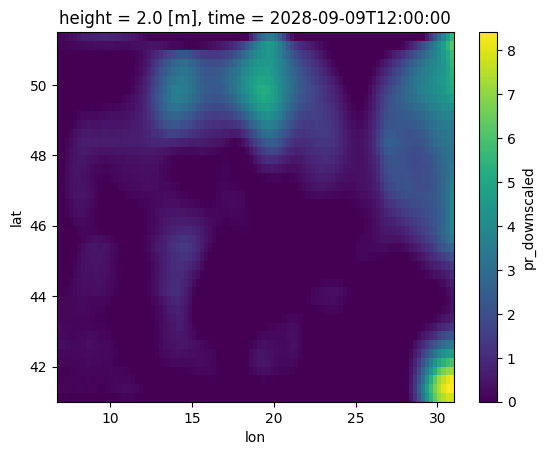

In [54]:
predicted_pr.isel(time=5000).plot() 

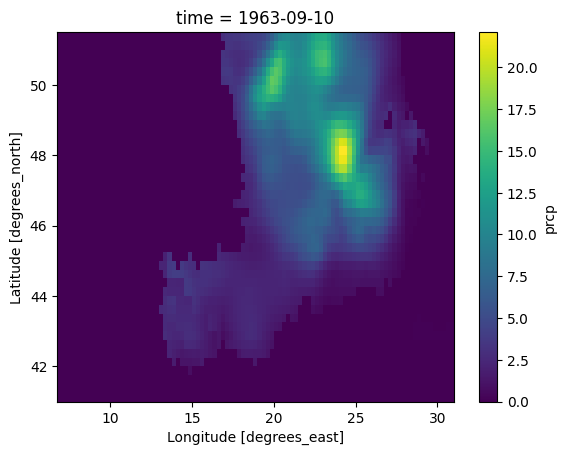

In [55]:
gmfd_pr['prcp'].isel(time=5000).plot() # Use .compute() if using Dask

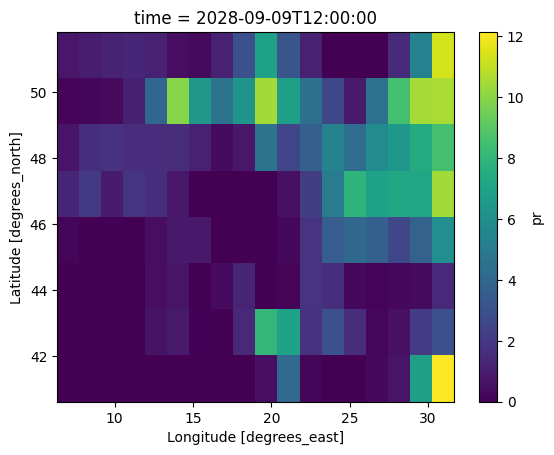

In [56]:
cmip6_sp126_pr['pr'].isel(time=5000).plot()  # Use .compute() if using Dask

#### SSP 245

In [57]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp245_tas_min = cmip6_sp245_high_res['tas'].min().values
cmip6_sp245_tas_max = cmip6_sp245_high_res['tas'].max().values
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
cmip6_sp245_norm = cmip6_sp245_norm.values
cmip6_sp245_norm_reshaped = cmip6_sp245_norm[..., np.newaxis]


cmip6_sp245_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_pr = xr.open_zarr(cmip6_sp245_pr)
cmip6_sp245_pr = cmip6_sp245_pr * 86400
cmip6_sp245_pr_high_res = cmip6_sp245_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_pr_high_res['pr'] = xr.where(cmip6_sp245_pr_high_res['pr'] < 0, 0, cmip6_sp245_pr_high_res['pr'])

cmip6_sp245_pr_high_res_log1p = cmip6_sp245_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp245_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp245_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp245_pr_min = cmip6_sp245_pr_high_res_log1p['pr'].min().values
cmip6_sp245_pr_max = cmip6_sp245_pr_high_res_log1p['pr'].max().values

cmip6_sp245_pr_norm_log1p = normalize(cmip6_sp245_pr_high_res_log1p ['pr'])
cmip6_sp245_pr_norm_log1p = cmip6_sp245_pr_norm_log1p.values
cmip6_sp245_pr_norm_log1p_reshaped = cmip6_sp245_pr_norm_log1p[..., np.newaxis]

cmip6_sp245_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_psl = xr.open_zarr(cmip6_sp245_psl)
cmip6_sp245_psl_high_res = cmip6_sp245_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_psl_norm = normalize(cmip6_sp245_psl_high_res['psl'])
cmip6_sp245_psl_norm = cmip6_sp245_psl_norm.values
cmip6_sp245_psl_norm_reshaped = cmip6_sp245_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp245_psl_norm_reshaped ), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp245_norm_reshaped, cmip6_sp245_pr_norm_log1p_reshaped, cmip6_sp245_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [58]:
# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
split_size = num_samples // 3  # Integer division to get the size of each split

# Split the dataset into three parts (approximately)
split1 = X_scen[:split_size]
split2 = X_scen[split_size:2*split_size]
split3 = X_scen[2*split_size:]

# Perform predictions on each split
predicted_split1 = model_saved.predict(split1)
predicted_split2 = model_saved.predict(split2)
predicted_split3 = model_saved.predict(split3)

# Concatenate the predictions
predicted_high_res = np.concatenate([predicted_split1, predicted_split2, predicted_split3], axis=0)

print(predicted_high_res.shape)

328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
(31411, 7, 42, 97, 2)


In [59]:
# temperature
predicted_high_res_tas = cmip6_sp245_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp245_tas_max- cmip6_sp245_tas_min) + cmip6_sp245_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan_ssp245.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp245_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp245_pr_max - cmip6_sp245_pr_min) + cmip6_sp245_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp245_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan_ssp245.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


#### SSP 585

In [60]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp585 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp585 = xr.open_zarr(cmip6_ssp585)
cmip6_sp585_high_res = cmip6_ssp585.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp585_tas_min = cmip6_sp585_high_res['tas'].min().values
cmip6_sp585_tas_max = cmip6_sp585_high_res['tas'].max().values
cmip6_sp585_norm = normalize(cmip6_sp585_high_res['tas'])
cmip6_sp585_norm = cmip6_sp585_norm.values
cmip6_sp585_norm_reshaped = cmip6_sp585_norm[..., np.newaxis]


cmip6_sp585_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_pr = xr.open_zarr(cmip6_sp585_pr)
cmip6_sp585_pr = cmip6_sp585_pr * 86400
cmip6_sp585_pr_high_res = cmip6_sp585_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp585_pr_high_res['pr'] = xr.where(cmip6_sp585_pr_high_res['pr'] < 0, 0, cmip6_sp585_pr_high_res['pr'])

cmip6_sp585_pr_high_res_log1p = cmip6_sp585_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp585_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp585_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp585_pr_min = cmip6_sp585_pr_high_res_log1p['pr'].min().values
cmip6_sp585_pr_max = cmip6_sp585_pr_high_res_log1p['pr'].max().values

cmip6_sp585_pr_norm_log1p = normalize(cmip6_sp585_pr_high_res_log1p ['pr'])
cmip6_sp585_pr_norm_log1p = cmip6_sp585_pr_norm_log1p.values
cmip6_sp585_pr_norm_log1p_reshaped = cmip6_sp585_pr_norm_log1p[..., np.newaxis]

cmip6_sp585_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_psl = xr.open_zarr(cmip6_sp585_psl)
cmip6_sp585_psl_high_res = cmip6_sp585_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp585_psl_norm = normalize(cmip6_sp585_psl_high_res['psl'])
cmip6_sp585_psl_norm = cmip6_sp585_psl_norm.values
cmip6_sp585_psl_norm_reshaped = cmip6_sp585_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp585_psl_norm), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp585_norm_reshaped, cmip6_sp585_pr_norm_log1p_reshaped, cmip6_sp585_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 

In [61]:
# Assuming X_scen has shape (23741, 7, 42, 97, 4)
num_samples = X_scen.shape[0]
split_size = num_samples // 3  # Integer division to get the size of each split

# Split the dataset into three parts (approximately)
split1 = X_scen[:split_size]
split2 = X_scen[split_size:2*split_size]
split3 = X_scen[2*split_size:]

# Perform predictions on each split
predicted_split1 = model_saved.predict(split1)
predicted_split2 = model_saved.predict(split2)
predicted_split3 = model_saved.predict(split3)

# Concatenate the predictions
predicted_high_res = np.concatenate([predicted_split1, predicted_split2, predicted_split3], axis=0)

print(predicted_high_res.shape)


# temperature
predicted_high_res_tas = cmip6_sp585_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp585_tas_max- cmip6_sp585_tas_min) + cmip6_sp585_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp585_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_tas_gan_ssp585.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp585_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp585_pr_max - cmip6_sp585_pr_min) + cmip6_sp585_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp585_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/gan/predicted_high_res_pr_gan_ssp585.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
(31411, 7, 42, 97, 2)
Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.
